Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
X_train shape: (4893, 130, 13, 1), X_val shape: (2097, 130, 13, 1), X_test shape: (2996, 130, 13, 1)
Epoch 1/100
153/153 [==============================] - 11s 67ms/step - loss: 2.0097 - accuracy: 0.3865 - val_loss: 2.7956 - val_accuracy: 0.2775
Epoch 2/100
153/153 [==============================] - 10s 67ms/step - loss: 1.3893 - accuracy: 0.5140 - val_loss: 1.3715 - val_accuracy: 0.5341
Epoch 3/100
153/153 [==============================] - 10s 68ms/step - loss: 1.2387 - accuracy: 0.5590 - val_loss: 1.5060 - val_accuracy: 0.5317
Epoch 4/100
153/153 [==============================] - 10s 67ms/step - loss: 1.1456 - accuracy: 0.6029 - val_loss: 1.2613 - val_accuracy: 0.5923
Epoch 5/100
153/153 [==============================] - 10s 67ms/step - loss: 1.0677 - accuracy: 0.6319 - val_loss: 1.2116 - val_accuracy: 0.5684
Epoch 6/100
153/153 [=============

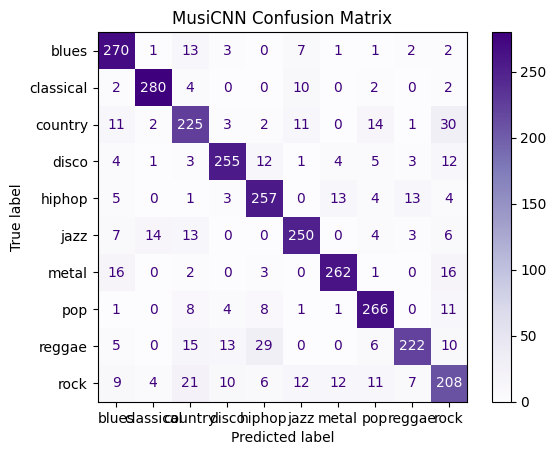

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import json

# Load data from data.json
with open('../Data/data.json', 'r') as fp:
    data = json.load(fp)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data to fix sample mismatch
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)

# Verify shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Reshape for CNN (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:4]
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

# Define MusiCNN model
model_musicnn = Sequential([
    # Timbral feature extraction (vertically long filters)
    Conv2D(64, (3, 7), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    # Temporal feature extraction (horizontally long filters)
    Conv2D(64, (7, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    # Additional convolutional layers for deeper feature extraction
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
model_musicnn.compile(
    optimizer=Adam(learning_rate=0.00251),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Data augmentation (vertical flip to simulate reversed audio)
datagen = ImageDataGenerator(vertical_flip=True)

# Train model
model_musicnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test set
loss, accuracy = model_musicnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save model
# model_musicnn.save('models/musicnn.keras')

# Optional: Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = np.argmax(model_musicnn.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Purples')
plt.title('MusiCNN Confusion Matrix')
plt.show()

In [7]:
model_musicnn.save('../models/musicnn.keras')